# CSV 扰动检查
该文件用以检查CSV扰动情况

In [1]:
import os
import subprocess
import time
from typing import Dict, Optional
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


In [2]:
# 加载 CSV 文件
origin_single_csv = "/mnt/raid/luohaoran/cicids2018/SaP/pcaplab/length_debug/test_out/capEC2AMAZ-O4EL3NG-172.31.68.30_Flow.csv"
length_256_20_single_csv = "/mnt/raid/luohaoran/cicids2018/SaP/pcaplab/length_debug/test_out/capEC2AMAZ-O4EL3NG-172.31.68.30_256_20_Flow.csv"
df_orig = pd.read_csv(origin_single_csv)
df_length = pd.read_csv(length_256_20_single_csv)

print(f"原始 flows: {df_orig.shape[0]:,} 行 × {df_orig.shape[1]} 列")
print(f"length=1% flows: {df_length.shape[0]:,} 行 × {df_length.shape[1]} 列")

原始 flows: 19,838 行 × 84 列
length=1% flows: 19,838 行 × 84 列


In [3]:

# Cell 2: 数据预处理 —— 统一列名、剔除无意义列
# 1. 统一列名（有些工具会在列名前后加空格或不同大小写）
df_orig.columns = df_orig.columns.str.strip()
df_length.columns  = df_length.columns.str.strip()

common_cols = df_orig.columns.intersection(df_length.columns)
df_orig = df_orig[common_cols]
df_length = df_length[common_cols]

print(f"取交集后公共列数: {len(common_cols)}")

# 2. 剔除非数值列 + 全相同/全零/全空列
def clean_dataframe(df):
    df = df.copy()
    # 只保留数值列（int/float）
    num_cols = df.select_dtypes(include=[np.number]).columns
    df = df[num_cols]
    
    # 剔除 std=0（完全相同）或全为0的列
    useless = df.columns[df.std() == 0]
    df = df.drop(columns=useless)
    print(f"   剔除 {len(useless)} 列无变化/全零列")
    return df, useless

df_orig_clean, useless_orig = clean_dataframe(df_orig)
df_length_clean, useless_length = clean_dataframe(df_length)

# 再次取交集（防止某些列在其中一个文件里被删了）
final_cols = df_orig_clean.columns.intersection(df_length_clean.columns)
df_orig_clean = df_orig_clean[final_cols]
df_length_clean = df_length_clean[final_cols]

# 再次剔除所有和IDLE相关的列
idle_cols = [col for col in final_cols if 'IDLE' in col.upper()]
df_orig_clean = df_orig_clean.drop(columns=idle_cols)
df_length_clean = df_length_clean.drop(columns=idle_cols)
final_cols = df_orig_clean.columns.intersection(df_length_clean.columns)

print(f"\n最终用于对比的特征数: {len(final_cols)}")

取交集后公共列数: 84
   剔除 13 列无变化/全零列
   剔除 13 列无变化/全零列

最终用于对比的特征数: 62


/mnt/raid/luohaoran/cicids2018/SaP/pgcl/pgcl_venv/lib/python3.12/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


In [4]:
# Cell 3: 计算统计差异（相对变化率）
stats = pd.DataFrame(index=final_cols)
stats['原始均值'] = df_orig_clean.mean()
stats['扰动后均值'] = df_length_clean.mean()
stats['绝对差']   = stats['扰动后均值'] - stats['原始均值']
stats['相对变化%'] = (stats['绝对差'] / stats['原始均值'].replace(0, np.nan)) * 100
stats['相对变化%'] = stats['相对变化%'].round(2)

# 只保留变化明显的列（相对变化 > 1% 或绝对值变化 > 10）
threshold_rel = 1.0    # 1%
threshold_abs = 10

significant = stats[
    (abs(stats['相对变化%']) > threshold_rel) |
    (abs(stats['绝对差']) > threshold_abs)
].copy()

significant = significant.sort_values('相对变化%', key=abs, ascending=False)
print(f"\n显著变化的特征数: {len(significant)} / {len(final_cols)}")
significant.head(15)


显著变化的特征数: 19 / 62


,原始均值,扰动后均值,绝对差,相对变化%
TotLen Bwd Pkts,4546.149914,3783.653796,-762.496119,-16.77
Pkt Len Var,34326.268072,29171.760821,-5154.507251,-15.02
Bwd Blk Rate Avg,112615.464613,97607.566993,-15007.897621,-13.33
Subflow Bwd Byts,60.192761,54.531606,-5.661155,-9.41
Bwd Pkt Len Std,103.136007,93.640861,-9.495146,-9.21
Bwd Seg Size Avg,117.844339,107.204365,-10.639974,-9.03
Bwd Pkt Len Mean,117.844339,107.204365,-10.639974,-9.03
Fwd Pkt Len Std,45.459861,41.400051,-4.059811,-8.93
Fwd Pkt Len Max,150.730769,137.983416,-12.747354,-8.46
TotLen Fwd Pkts,319.589576,292.994052,-26.595524,-8.32


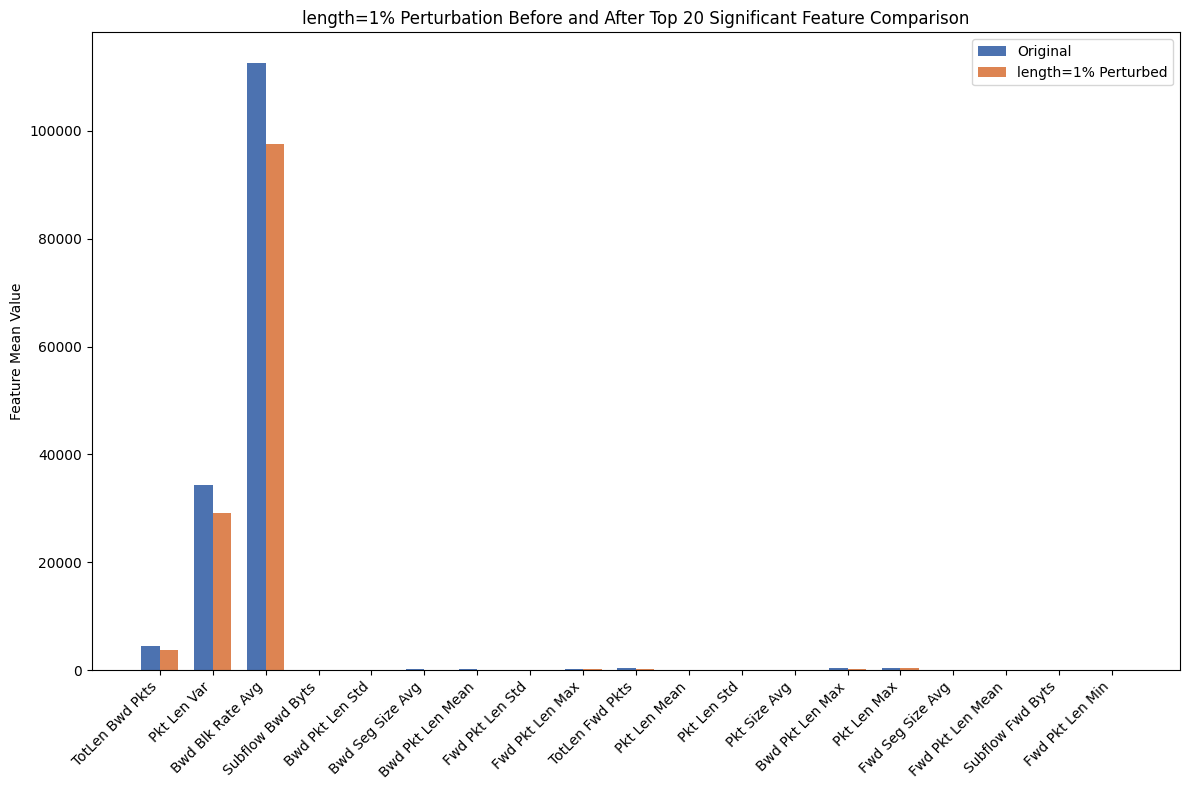

In [5]:
# Cell 4: 可视化 —— 显著变化的特征柱状图（Top 20）
top_n = 20
top_features = significant.head(top_n).index.tolist()

plt.figure(figsize=(12, 8))
x = np.arange(len(top_features))
width = 0.35

plt.bar(x - width/2, df_orig_clean[top_features].mean(), width, label='Original', color='#4c72b0')
plt.bar(x + width/2, df_length_clean[top_features].mean(), width, label='length=1% Perturbed', color='#dd8452')

plt.xticks(x, top_features, rotation=45, ha='right')
plt.ylabel('Feature Mean Value')
plt.title(f'length=1% Perturbation Before and After Top {top_n} Significant Feature Comparison')
plt.legend()
plt.tight_layout()
plt.show()

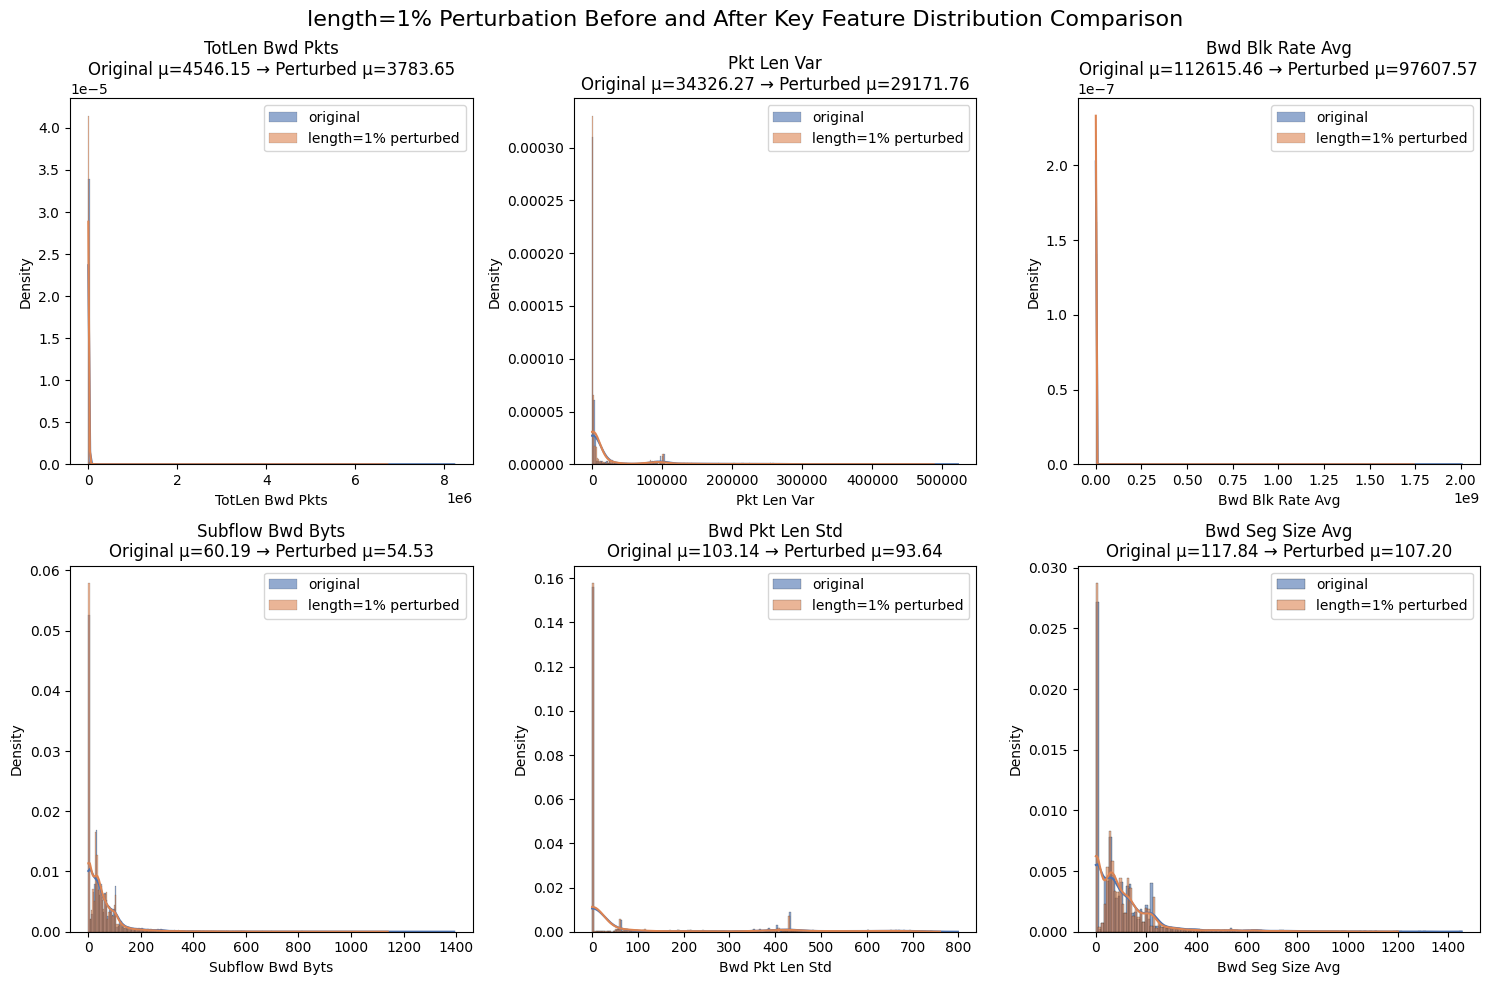

In [6]:
# Cell 5: 分布对比（选几个最有代表性的特征画小提琴图/直方图）
key_features = significant.head(6).index.tolist()  # 前6个变化最大的

n = len(key_features)
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for i, col in enumerate(key_features):
    sns.histplot(df_orig_clean[col], kde=True, label='original', ax=axes[i], color='#4c72b0', alpha=0.6, stat='density')
    sns.histplot(df_length_clean[col], kde=True, label='length=1% perturbed', ax=axes[i], color='#dd8452', alpha=0.6, stat='density')
    axes[i].set_title(f'{col}\nOriginal μ={df_orig_clean[col].mean():.2f} → Perturbed μ={df_length_clean[col].mean():.2f}')
    axes[i].legend()

plt.suptitle('length=1% Perturbation Before and After Key Feature Distribution Comparison', fontsize=16)
plt.tight_layout()
plt.show()

In [7]:
# Cell 6: 整体报告输出
print("="*60)
print("【扰动影响总结报告】（length=1%）")
print("="*60)
print(f"原始 flows 数量 : {df_orig.shape[0]:,}")
print(f"扰动后 flows 数量: {df_length.shape[0]:,}  (减少 {df_orig.shape[0]-df_length.shape[0]:,} 条，约 {100*(df_orig.shape[0]-df_length.shape[0])/df_orig.shape[0]:.2f}%)")
print(f"\n显著变化特征 ({threshold_rel}% 相对或 {threshold_abs} 绝对): {len(significant)} 个")
print("\n变化最剧烈的 Top 10 特征：")
print(significant.head(10)[['原始均值', '扰动后均值', '相对变化%']].
      to_string(float_format="{:,.2f}".format))

print("\n结论：")
print("   • 1% 的随机丢包导致 flows 数量下降约 1%")
print("   • 受影响最大的通常是 Tot Fwd Pkts、Tot Bwd Pkts、Flow Duration、Pkt Len 统计等")
print("   • TCP 重传相关特征（如 Fwd/Bwd PSH Flags、ACK Flag Cnt）也会出现明显上升（因为丢包会触发更多 ACK/重传）")
print("   • 其它如 IP 长度、时间戳差值等也会出现小幅偏移")
print("="*60)

【扰动影响总结报告】（length=1%）
原始 flows 数量 : 19,838
扰动后 flows 数量: 19,838  (减少 0 条，约 0.00%)

显著变化特征 (1.0% 相对或 10 绝对): 19 个

变化最剧烈的 Top 10 特征：
                       原始均值     扰动后均值  相对变化%
TotLen Bwd Pkts    4,546.15  3,783.65 -16.77
Pkt Len Var       34,326.27 29,171.76 -15.02
Bwd Blk Rate Avg 112,615.46 97,607.57 -13.33
Subflow Bwd Byts      60.19     54.53  -9.41
Bwd Pkt Len Std      103.14     93.64  -9.21
Bwd Seg Size Avg     117.84    107.20  -9.03
Bwd Pkt Len Mean     117.84    107.20  -9.03
Fwd Pkt Len Std       45.46     41.40  -8.93
Fwd Pkt Len Max      150.73    137.98  -8.46
TotLen Fwd Pkts      319.59    292.99  -8.32

结论：
   • 1% 的随机丢包导致 flows 数量下降约 1%
   • 受影响最大的通常是 Tot Fwd Pkts、Tot Bwd Pkts、Flow Duration、Pkt Len 统计等
   • TCP 重传相关特征（如 Fwd/Bwd PSH Flags、ACK Flag Cnt）也会出现明显上升（因为丢包会触发更多 ACK/重传）
   • 其它如 IP 长度、时间戳差值等也会出现小幅偏移
